## Project 2 IPYNB code (Eric Wong) 

## Imports

In [621]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from numbers import Number
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 
%matplotlib inline

## Training and Test Merge to clean data
#####  -- TESTING DATA WILL BE SLICED OUT BEFORE TRAINING --

In [622]:
df = pd.read_csv('..//project-2//datasets//train.csv')
df.shape

(2051, 81)

In [623]:
dft = pd.read_csv('..//project-2//datasets//test.csv')
dft.shape
#missing price column

(879, 80)

In [624]:
df = df.append(dft)
df.shape

(2930, 81)

In [625]:
df.reset_index(inplace=True, drop=True)

In [626]:
#Column names to lowercase and no spaces
df.rename(columns= lambda x: x.replace(' ', '_'), inplace=True)
df.columns = df.columns.str.lower()

In [627]:
df.isnull().sum().head()

1st_flr_sf          0
2nd_flr_sf          0
3ssn_porch          0
alley            2732
bedroom_abvgr       0
dtype: int64

## Data Cleaning

In [628]:
# Data Cleaning of columns based on Documentation
#    If the column was a catergorial/string, we gave flags 1 for non-nan values.
#    If the column was continous and a value of 0 was justifiable (such as not having a basement), NaNs were replaced with 0.
#Arguably, we may not want to add nobasement data to basement data, however for larger correlative analysis it will provide a
#greater aggregate view.
#    If the column had documentatation which explained NA values, it was addressed accordingly.

In [629]:
# Lots Frontage -> Replace 0 for missing NaN
df['lot_frontage'] = [x if x >= 0 else 0 for x in df.lot_frontage]

In [630]:
#Alley NaN -> FillNA with NoAlley (No Alley)
df.alley.fillna('Noalley', inplace =True)

In [631]:
#Masonary Veneer -> 
df['mas_vnr_type'] = [x if x == str(x) else 'None' for x in df.mas_vnr_type]

In [632]:
#Masonary area - > FillNA with 0 (Rows with NA veneer are same as area. Imply No Veener == 0 area)
df['mas_vnr_area'].fillna('0', inplace =True)

In [633]:
#Basement Qualtiy -> FillNA with Nobase (No Basement)
df['bsmt_qual'] = [x if x == str(x) else 'Nobase' for x in df.bsmt_qual]

In [634]:
#Basement Condition - > FillNA with Nobase (No Basement)
df['bsmt_cond'] = [x if x == str(x) else 'Nobase' for x in df.bsmt_cond]

In [635]:
#Basement Exposure - > FillNA with Nobase (No Basement)
df['bsmt_exposure'] = [x if x == str(x) else 'Nobase' for x in df.bsmt_exposure]

In [636]:
#Basement Type 1 - > FillNA with Nobase (No Basement)
df['bsmtfin_type_1'] = [x if x == str(x) else 'Nobase' for x in df.bsmtfin_type_1]

In [637]:
#Basement type1 finished sqft - > FillNA with 0 (Checked out and says No Basement)
df[df.bsmtfin_sf_1.isnull() == True]['bsmtfin_type_1']
df['bsmtfin_sf_1'].fillna('0', inplace =True)

In [638]:
#Basement Type 2 - > FillNA with Nobase (No Basement)
df['bsmtfin_type_2'] = [x if x == str(x) else 'Nobase' for x in df.bsmtfin_type_2]

In [639]:
#Basement type2 finished sqft - > FillNA with 0 (Checked out and says  No Basement)
df[df.bsmtfin_sf_2.isnull() == True]['bsmtfin_type_2']
df['bsmtfin_sf_2'].fillna('0', inplace =True)

In [640]:
#Basement unfinished sqft - > FillNA with 0 (Checked out and says No Basement)
df[df.bsmt_unf_sf.isnull() == True]['bsmt_qual']
df['bsmt_unf_sf'].fillna('0', inplace =True)

In [641]:
#Total Basement Sq.Ft - > FillNA with 0 (Checked out and says No Basement)
df[df.total_bsmt_sf.isnull() == True]['total_bsmt_sf']
df['total_bsmt_sf'].fillna('0', inplace =True)

In [642]:
#Fireplace Quality - > FillNA with Nofp (No Fireplace)
df['fireplace_qu'] = [x if x == str(x) else 'Nofp' for x in df.fireplace_qu]

In [643]:
#Garage Type -> Fillna Nog(No garage)
df.garage_type.fillna('Nog', inplace = True)

In [644]:
#Garage finish - > FillNA Nog (No garage)
df.garage_finish.fillna('Nog', inplace=True)

In [645]:
# Number of cars garage can fit -> FillNA 
df.garage_cars.fillna(0, inplace =True)

In [646]:
# Size of garage -> FillNA
df.garage_area.fillna(0, inplace=True)

In [647]:
#Garage Quality - > FillNA Nog (No garage)
df.garage_qual.fillna('Nog', inplace=True)

In [648]:
#Garage Condition -> FillNa Nog (No Garage)
df.garage_cond.fillna('Nog', inplace=True)

In [649]:
#Pool Quality -> Fillna NP (No Pool)
df.pool_qc.fillna('NP', inplace=True)

In [650]:
#Fence -> FillNA NF (No Fence)
df.fence.fillna('NF', inplace=True)

## Setting correct data type

In [651]:
# Setting appropriate column type
df = df.apply(pd.to_numeric, errors='ignore', axis=1)

In [652]:
df.mas_vnr_area = [int(x) for x in df.mas_vnr_area]
df.bsmtfin_sf_1 = [int(x) for x in df.bsmtfin_sf_1]
df.bsmtfin_sf_2 = [int(x) for x in df.bsmtfin_sf_2]
df.bsmt_unf_sf = [int(x) for x in df.bsmt_unf_sf]
df.total_bsmt_sf = [int(x) for x in df.total_bsmt_sf]

## Split Train and Testing again as to not affect index from dropping 

In [653]:
Xdata = df[0:2051]
Tdata = df[2051:]
Tdata.shape

(879, 81)

In [654]:
Xdata['exter_qual'].value_counts()/ len(Xdata['exter_qual'])

TA    0.607996
Gd    0.339834
Ex    0.039493
Fa    0.012677
Name: exter_qual, dtype: float64

In [655]:
Xdata.isnull().sum()[Xdata.isnull().sum() != 0]

bsmt_full_bath       2
bsmt_half_bath       2
garage_yr_blt      114
misc_feature      1986
dtype: int64

In [656]:
#bsmt_full_bath -> Drop rows
#bsmt_half_bath -> Drop rows
#garage_yr_blt -> Remove from features
#misc_feature -> Remove from features

## Dropping  small NULL values from Training set

In [657]:
#Dropping from Xdata bsmt_full_bath, bsmt_half_bath
Xdata.dropna(subset = ['bsmt_full_bath'], inplace = True)
Xdata.dropna(subset = ['bsmt_half_bath'], inplace = True)

## Fixing NULL value from Testing set

In [658]:
Tdata.isnull().sum()[Tdata.isnull().sum() != 0]

electrical         1
garage_yr_blt     45
misc_feature     838
saleprice        879
dtype: int64

In [659]:
#electrical is one data point. I wouldn't normall put false info but will fill with SKbrkr as most common datapoint
#saleprice will be dropped from Test Data
#garage_yr_blt -> Remove from features
#misc_feature -> Remove from features

In [660]:
Tdata['electrical'].isnull()[Tdata.electrical.isnull()]
#Tdata electrical loc is 2686 NOT actual index
Tdata['electrical'].value_counts()

SBrkr    814
FuseA     48
FuseF     15
FuseP      1
Name: electrical, dtype: int64

In [661]:
# Used most common value. Unlikely to skew data
Tdata['electrical'] = Tdata['electrical'].fillna('SBrkr')

In [662]:
Tdata = Tdata.drop('saleprice', axis=1)
Tdata.isnull().sum()[Tdata.isnull().sum() != 0]

garage_yr_blt     45
misc_feature     838
dtype: int64

In [663]:
#Resetting Tdata Index
Tdata.reset_index(inplace=True, drop=True)

## Dummy Variables 

In [664]:
# Getting dummies for catergorial values 
dummylist=[]
for x in range(0, len(Tdata.columns)):
    if Tdata.dtypes[x] == object:
        dummylist.append(Tdata.columns[x])

In [665]:
Xdata = pd.get_dummies(Xdata, columns=dummylist, drop_first=True)

In [666]:
Tdata = pd.get_dummies(Tdata, columns=dummylist, drop_first=True)

## Feature Selection/EDA

In [667]:
features = list(set(Xdata.columns).intersection(Tdata.columns))
features.append('saleprice')
features.remove('garage_yr_blt')

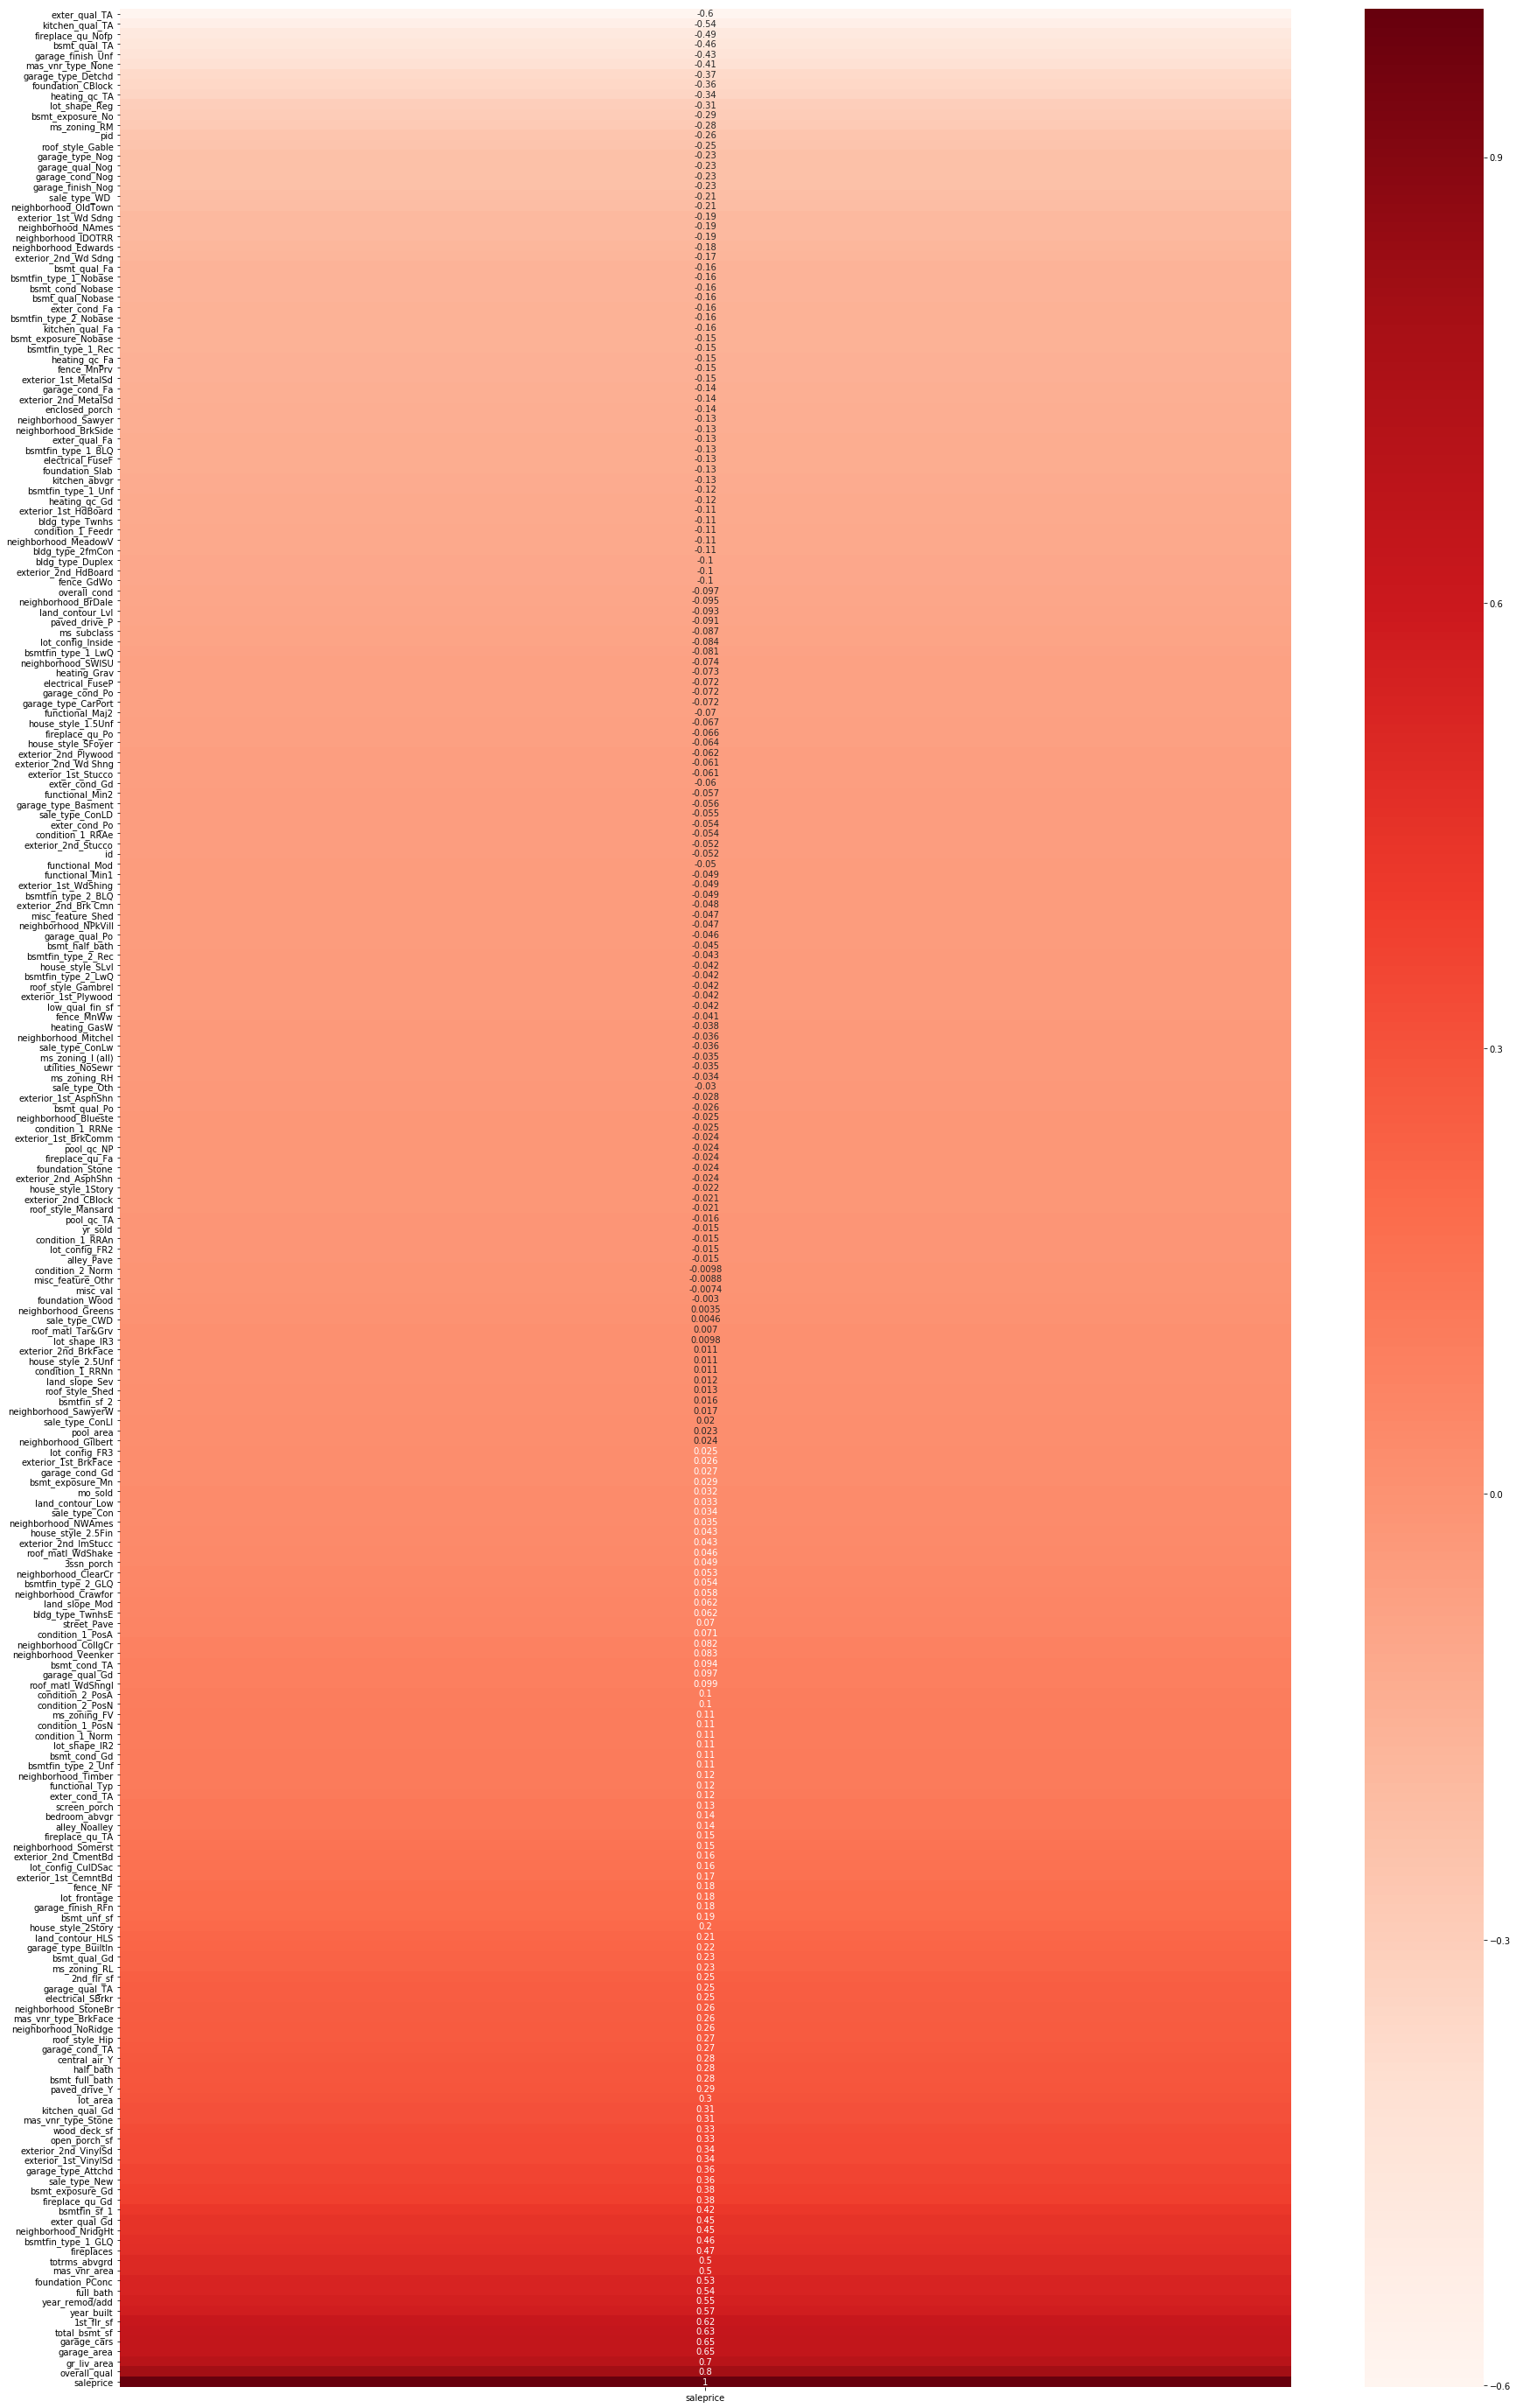

In [668]:
plt.figure(figsize=(30,50))
sns.heatmap(Xdata[features].corr()[['saleprice']].sort_values('saleprice'), cmap='Reds', annot=True)

In [669]:
##Revised Featrues based on correlation and variables greater than 20% correlation to sales price.
features = [x for x in features if (abs(Xdata[x].corr(Xdata['saleprice'])) >= .2)]

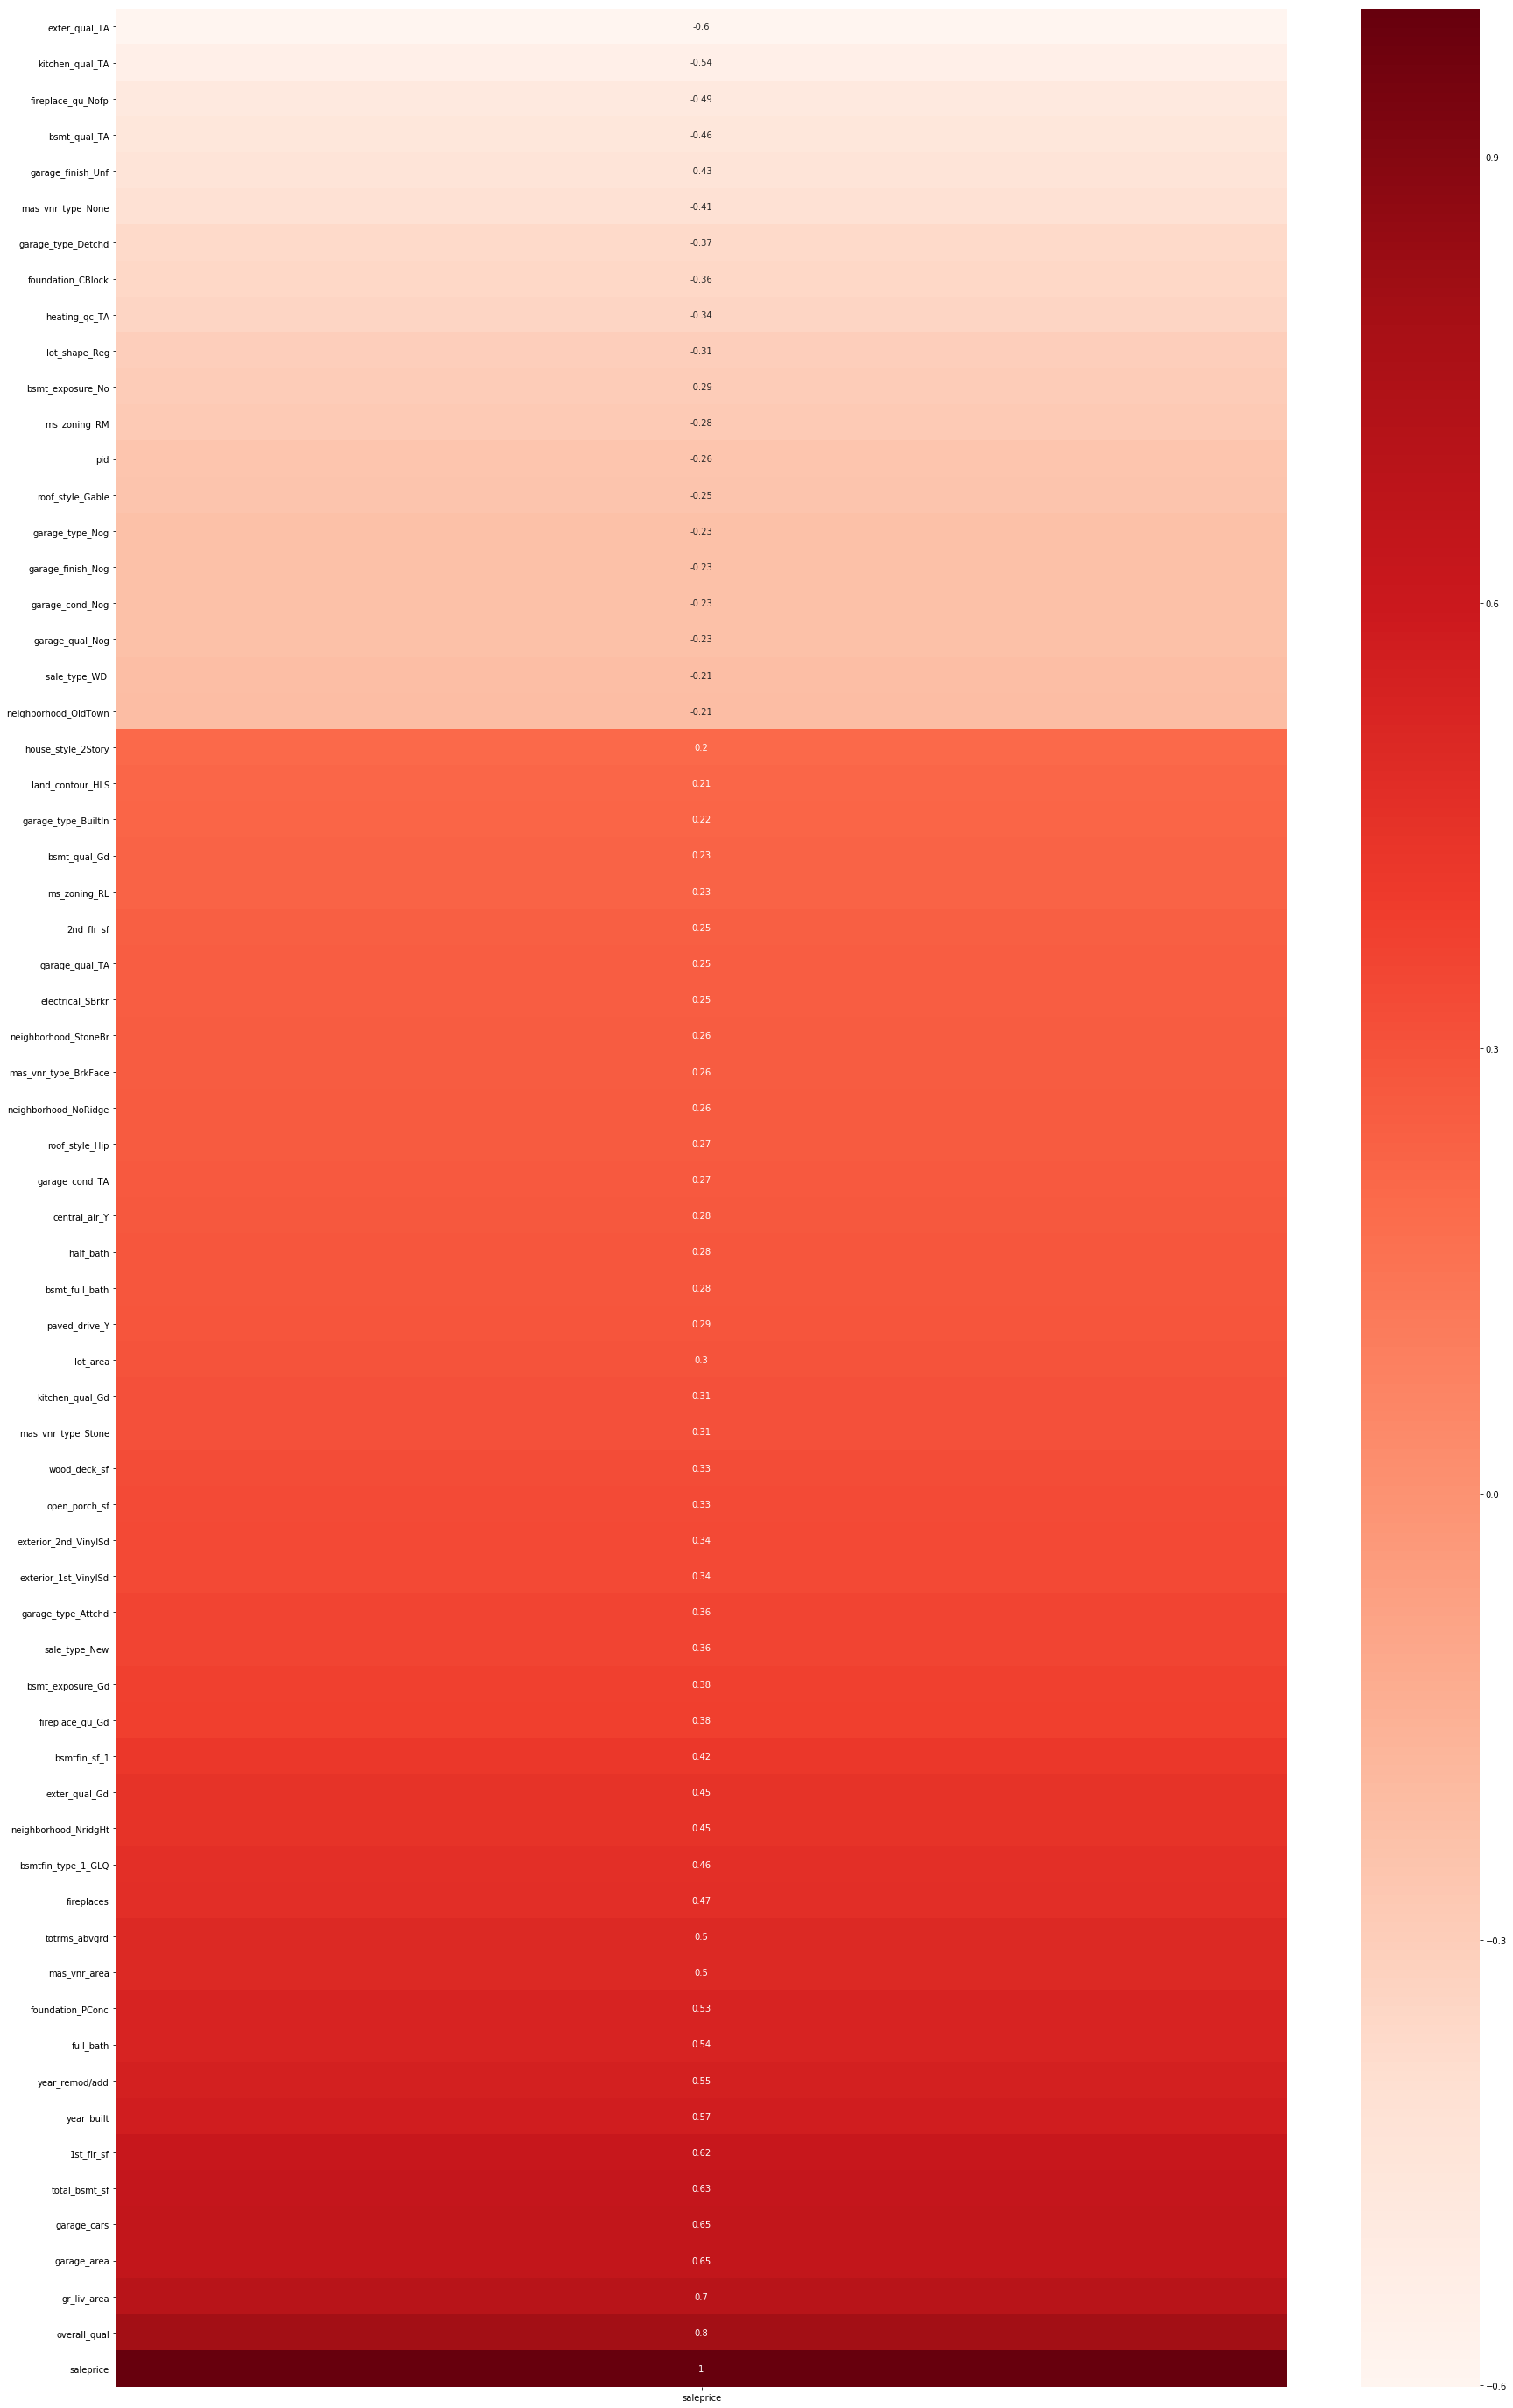

In [670]:
plt.figure(figsize=(30,50))

sns.heatmap(Xdata[features].corr()[['saleprice']].sort_values('saleprice'), cmap='Reds', annot=True)

In [671]:
#Features list
FeaturesList = features
FeaturesList.sort()
print(FeaturesList)

['1st_flr_sf', '2nd_flr_sf', 'bsmt_exposure_Gd', 'bsmt_exposure_No', 'bsmt_full_bath', 'bsmt_qual_Gd', 'bsmt_qual_TA', 'bsmtfin_sf_1', 'bsmtfin_type_1_GLQ', 'central_air_Y', 'electrical_SBrkr', 'exter_qual_Gd', 'exter_qual_TA', 'exterior_1st_VinylSd', 'exterior_2nd_VinylSd', 'fireplace_qu_Gd', 'fireplace_qu_Nofp', 'fireplaces', 'foundation_CBlock', 'foundation_PConc', 'full_bath', 'garage_area', 'garage_cars', 'garage_cond_Nog', 'garage_cond_TA', 'garage_finish_Nog', 'garage_finish_Unf', 'garage_qual_Nog', 'garage_qual_TA', 'garage_type_Attchd', 'garage_type_BuiltIn', 'garage_type_Detchd', 'garage_type_Nog', 'gr_liv_area', 'half_bath', 'heating_qc_TA', 'house_style_2Story', 'kitchen_qual_Gd', 'kitchen_qual_TA', 'land_contour_HLS', 'lot_area', 'lot_shape_Reg', 'mas_vnr_area', 'mas_vnr_type_BrkFace', 'mas_vnr_type_None', 'mas_vnr_type_Stone', 'ms_zoning_RL', 'ms_zoning_RM', 'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_OldTown', 'neighborhood_StoneBr', 'open_porch_sf', 'o

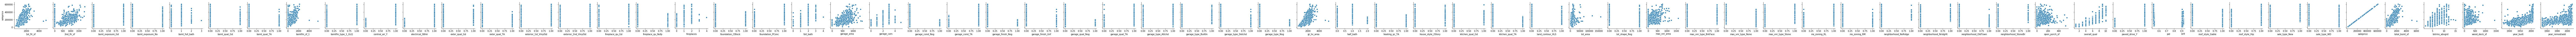

In [672]:
sns.pairplot(data= Xdata,  y_vars = ['saleprice'], x_vars=FeaturesList);

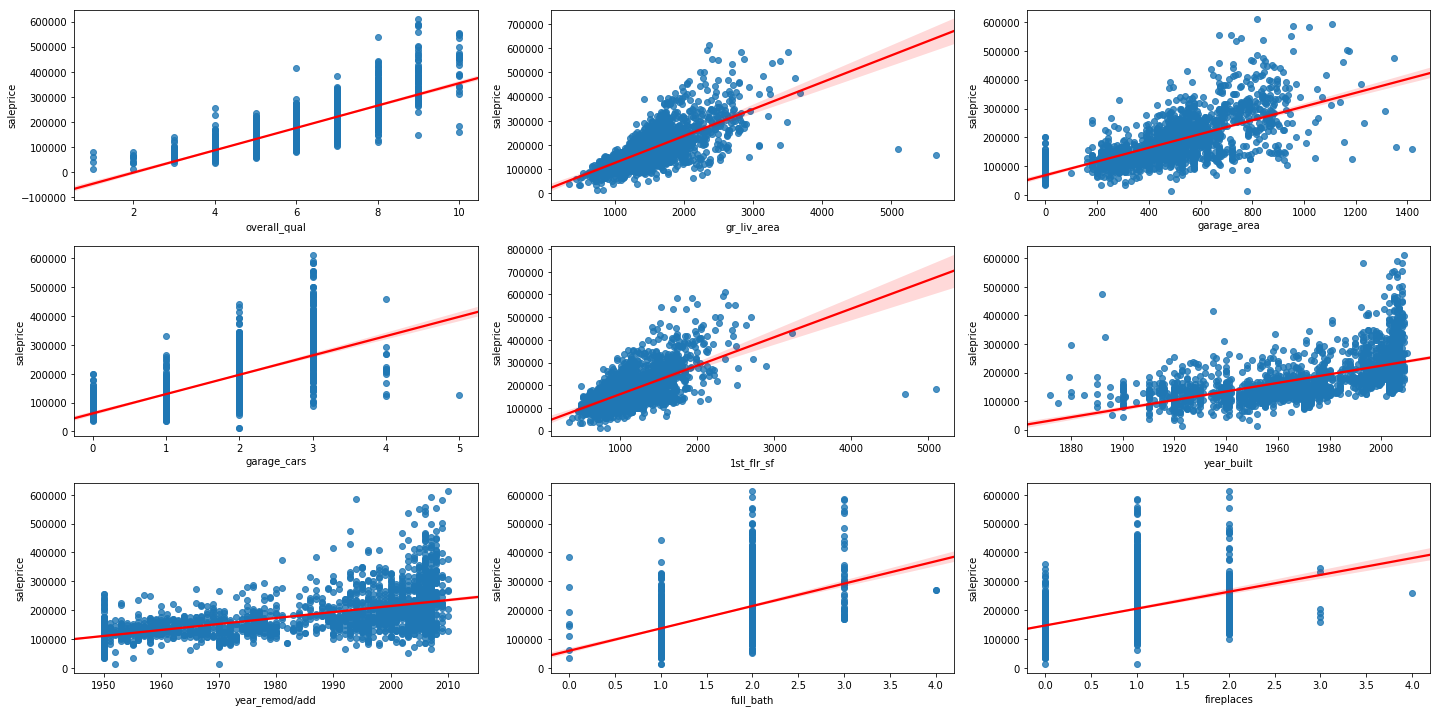

In [673]:
#Data with high correlative % with SalePrice (Positive)
f, axes = plt.subplots(3,3, figsize =(20,10))
plt.subplot(3,3,1)
sns.regplot(Xdata.overall_qual, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,2)
sns.regplot(Xdata.gr_liv_area, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,3)
sns.regplot(Xdata.garage_area, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,4)
sns.regplot(Xdata.garage_cars, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,5)
sns.regplot(Xdata['1st_flr_sf'], Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,6)
sns.regplot(Xdata.year_built, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,7)
sns.regplot(Xdata['year_remod/add'], Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,8)
sns.regplot(Xdata.full_bath, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,9)
sns.regplot(Xdata.fireplaces, Xdata.saleprice, line_kws={'color':'red'})
plt.tight_layout()

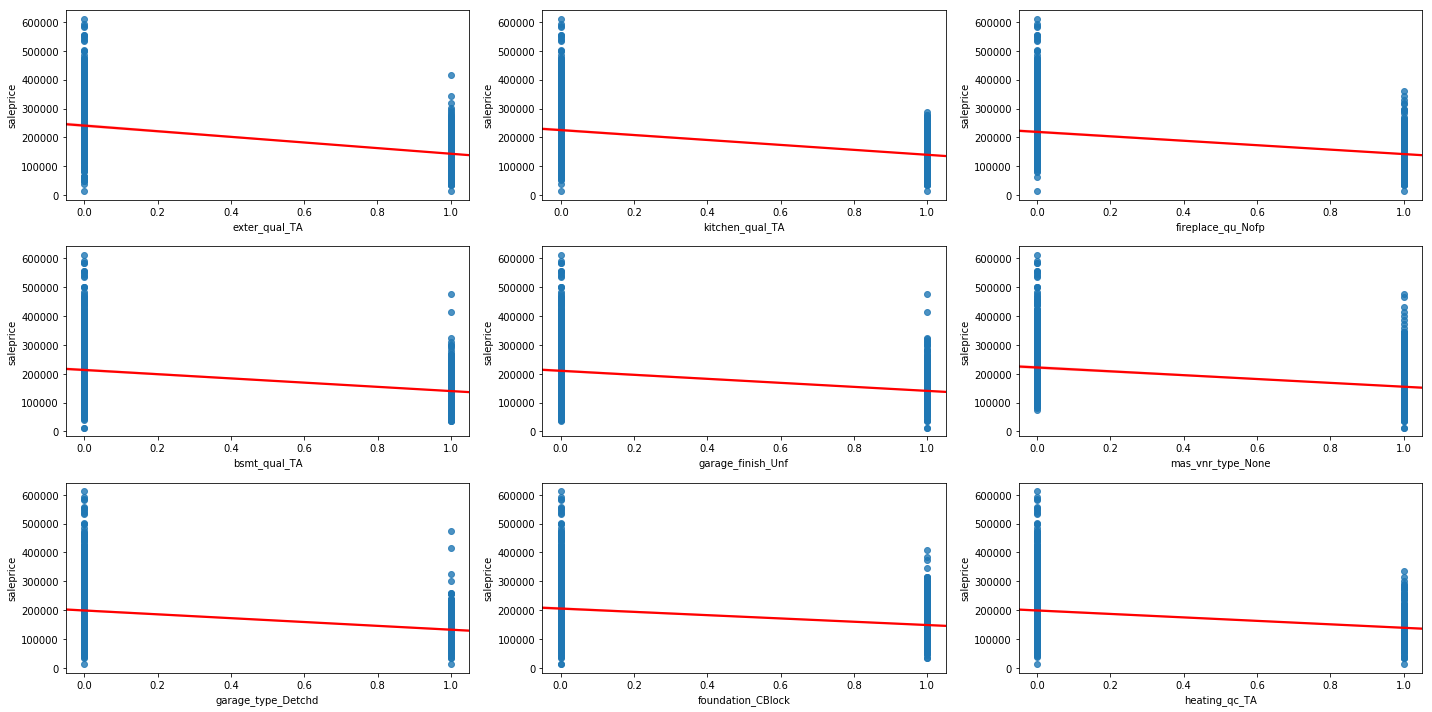

In [674]:
#Data with high correlative % with SalePrice (Negative)
f, axes = plt.subplots(3,3, figsize =(20,10))
plt.subplot(3,3,1)
sns.regplot(Xdata.exter_qual_TA, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,2)
sns.regplot(Xdata.kitchen_qual_TA, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,3)
sns.regplot(Xdata.fireplace_qu_Nofp, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,4)
sns.regplot(Xdata.bsmt_qual_TA, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,5)
sns.regplot(Xdata['garage_finish_Unf'], Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,6)
sns.regplot(Xdata.mas_vnr_type_None, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,7)
sns.regplot(Xdata['garage_type_Detchd'], Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,8)
sns.regplot(Xdata.foundation_CBlock, Xdata.saleprice, line_kws={'color':'red'})
plt.subplot(3,3,9)
sns.regplot(Xdata.heating_qc_TA, Xdata.saleprice, line_kws={'color':'red'})
plt.tight_layout()

In [675]:
y = Xdata['saleprice']

In [676]:
features.remove('saleprice')
X = Xdata[features]
T = Tdata[features]

## Standard Scaling

In [677]:
ss = StandardScaler()
ss.fit(X)
X_train = ss.transform(X)
X_test = ss.transform(T)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


## Model Building

In [678]:
lr = LinearRegression()
lr.fit(X_train, y)
lrpred = lr.predict(X_test)

In [679]:
lrdata = pd.DataFrame(lrpred)
lrdata.columns = ['SalePrice']
lrdata.head()
indexid = pd.DataFrame(Tdata.id)
Sub = pd.merge(lrdata, indexid, left_index=True, right_index=True)
Sub = pd.DataFrame(Sub)
Sub = Sub[['id', 'SalePrice']]
Sub.columns = ['Id', 'SalePrice']

In [680]:
Sub.to_csv('P2EW.csv', index=False)

In [681]:
#Fitting regres
lr = LinearRegression()
lr.fit(X_train, y)
lrpred = lr.predict(X_train)

In [682]:
lr.score(X_train, y)

0.8685366121491627

In [683]:
lr.coef_

array([ 8.08326984e+03,  1.17986927e+04,  4.92156344e+03, -1.74248726e+03,
        3.98318723e+03, -6.30723282e+03, -2.47146461e+03,  2.01539830e+03,
        1.55056142e+03,  2.43454802e+03, -1.55961761e+01, -6.07164696e+03,
       -6.86053390e+03, -3.31111116e+03,  4.81319513e+03,  1.36595481e+03,
        6.48811568e+02,  5.36093145e+03,  1.28865989e+03,  2.68302634e+03,
        1.88267781e+03,  4.72457418e+03,  4.39005690e+03, -8.86963876e+16,
        2.05401175e+03,  4.50294065e+16, -8.41845397e+02,  4.36669811e+16,
       -3.42626285e+03,  8.70576388e+03,  4.45922683e+03,  6.64286333e+03,
       -1.67403875e+03,  4.88552165e+03,  1.00948041e+03, -2.83006919e+03,
       -4.19222100e+03, -1.01402406e+04, -1.07908100e+04,  2.61396175e+03,
        4.37933801e+03, -1.45563145e+03,  2.91119382e+03,  9.60530370e+03,
        1.18924491e+04,  5.16832931e+03, -2.47533294e+03, -4.93327570e+03,
        6.60560849e+03,  8.08408131e+03, -8.21505372e+02,  5.56989811e+03,
        1.11997670e+03,  

In [684]:
FS = np.sqrt(mean_squared_error(y, lrpred ))
print('Root Mean Square Error of ',  round(FS,2))

Root Mean Square Error of  28720.9


## Ridge Regularization (Choice Ridge due to multiple factors and hypothesized multi-colinearity) 

In [685]:
rcv = RidgeCV(alphas=np.linspace(.1, 10, 100), cv= 10)
rcv.fit(X_train, y)
rcvpred = rcv.predict(X_train)
rcv.score(X_train, y)

0.8689362119463805

In [686]:
cross_val_score(rcv, X_train, y, cv=10).mean()

0.8422755277830145

In [687]:
FS = np.sqrt(mean_squared_error(y, rcvpred))
print('Root Mean Square Error of Ridge',  round(FS,2))
#Slightly better than Linear Regression

Root Mean Square Error of Ridge 28677.22


## Elastic net CV

In [688]:
ecv = ElasticNetCV(n_alphas=200, l1_ratio=[.01, .25,.50,.75, 1], cv=10)
ecv.fit(X_train, y)
ecvpred =ecv.predict(X_train)
ecv.score(X_train, y)

0.8682832538248496

In [689]:
cross_val_score(ecv, X_train, y, cv=10).mean()

0.8419985880465498

In [690]:
FS = np.sqrt(mean_squared_error(y, ecvpred))
print('Root Mean Square Error of Elastic Net',  round(FS,2))

Root Mean Square Error of Elastic Net 28748.56


In [691]:
ecv.l1_ratio_
#Due to the Elastic net CV choosing a high lasso coefficent, likely a lasso regularization would be the best answer

1.0

## Elastic net suggests a Lasso CV

In [692]:
lcv = LassoCV(n_alphas=200, cv=10)
lcv.fit(X_train, y)
lcvpred = lcv.predict(X_train)
lcv.score(X_train, y)

0.8682832538248496

In [693]:
cross_val_score(lcv, X_train, y, cv=10).mean()

0.8419985880465498

In [694]:
FS = np.sqrt(mean_squared_error(y, lcvpred))
print('Root Mean Square Error of Elastic Net',  round(FS,2))
#Not expected to have RMSE but likely a better prediction model

Root Mean Square Error of Elastic Net 28748.56


In [695]:
lcv.alpha_

103.15002373841361

In [696]:
lcv.coef_

array([  2503.73084196,   5480.80323213,   4627.19878352,  -1642.48975502,
         3616.56192779,  -6127.4688725 ,  -2447.33717541,   2689.52620573,
         1642.59907905,   2195.73275626,     -0.        ,  -5198.14930336,
        -6567.53264786,      0.        ,   1320.31981528,   1410.32597519,
           -0.        ,   4556.35077597,    513.5977751 ,   1809.07015202,
         1788.85130376,   3938.96136217,   5174.30607521,   1259.66997469,
         1206.3553943 ,    521.19650334,    -49.31618623,    210.96068798,
        -3106.91781795,   5780.25947037,   2891.8262876 ,   3819.61312374,
            0.        ,  12285.94282156,   1296.33146652,  -2393.09304357,
        -3386.84055001,  -9061.84254112, -10044.02929726,   2583.9197569 ,
         4244.67292622,   -747.57433093,   3064.18210453,      0.        ,
         1737.41468357,      0.        ,  -1160.83319752,  -4158.6282601 ,
         6110.14588879,   7473.15849235,   -474.56766696,   5513.92415242,
          476.79710128,  

In [697]:
newlist = []
for x in lcv.coef_:
    newlist.append(x)
newlist = pd.DataFrame(newlist)
newlist1 = pd.DataFrame(features)

In [698]:
featureco = pd.concat([newlist, newlist1], axis=1) 

In [699]:
featureco.columns = ['Coefficent', 'Feature']

In [700]:
featureco.sort_values(by =['Coefficent'])

,Coefficent,Feature
38,-10044.029297,kitchen_qual_TA
37,-9061.842541,kitchen_qual_Gd
12,-6567.532648,exter_qual_TA
5,-6127.468873,bsmt_qual_Gd
11,-5198.149303,exter_qual_Gd
47,-4158.628260,ms_zoning_RM
36,-3386.840550,house_style_2Story
28,-3106.917818,garage_qual_TA
6,-2447.337175,bsmt_qual_TA
35,-2393.093044,heating_qc_TA


In [704]:
import eli5
eli5.show_weights(X.saleprice, target_names= X.columns, top=20)

AttributeError: 'DataFrame' object has no attribute 'saleprice'